In [165]:
import numpy as np
from scipy.fft import fft, ifft, rfft, irfft, fftfreq
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from matplotlib import rcParams
import matplotlib.animation as animation
import time

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [166]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

In [167]:
inputfile = "GI parameters - Reference limit cycle copy.nml"

In [168]:
# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle copy.nml ...

From the GrowthInstability (GI) namelist:
D = 0.000365 micrometer ** 2 / microsecond
L = 30 micrometer
nx (crystal) = 150
odemethod = RK45


In [169]:
# Conversions (in case inputs are in other units)
D.ito('micrometer^2/microsecond')
L.ito('micrometer')

In [170]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
DoverdeltaX2 = D/deltax**2
print(deltax ** 2)

Spacing of points on the ice surface = 0.40268456375838824 micrometer
0.16215485788928344 micrometer ** 2


In [171]:
def diffusion_term_cart(NQLL0, DoverdeltaX2):
    dy = np.empty(np.shape(NQLL0))
    for i in range(1,len(NQLL0)-1):
        dy[i] = DoverdeltaX2*(NQLL0[i-1]-2*NQLL0[i]+NQLL0[i+1])
    dy[0]  = DoverdeltaX2*(NQLL0[-1] -2*NQLL0[0] +NQLL0[1]) # Periodic BC
    dy[-1] = DoverdeltaX2*(NQLL0[-2] -2*NQLL0[-1]+NQLL0[0])
    
    return dy

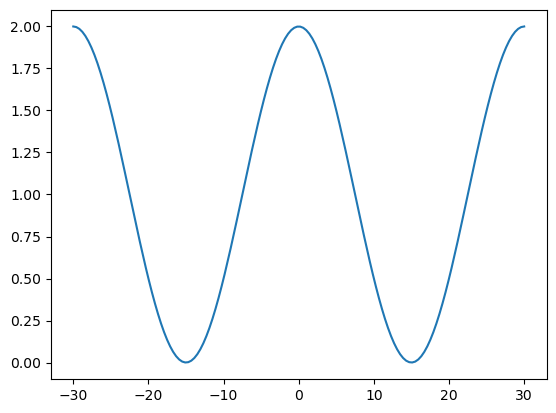

In [172]:
NQLL0 = np.cos(x_QLC * 2 * np.pi / L) + 1
plt.figure()
plt.plot(x_QLC.magnitude, NQLL0)

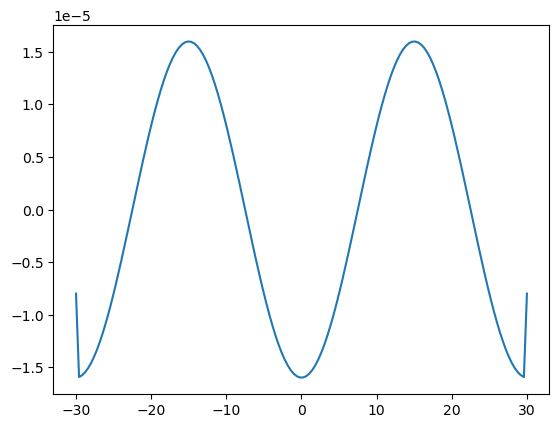

In [173]:
test = diffusion_term_cart(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test)

In [174]:
#test diffusion term function

"""
test_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)
plt.figure()
plt.plot(x_QLC.magnitude, test_analytical)
"""

'\ntest_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)\nplt.figure()\nplt.plot(x_QLC.magnitude, test_analytical)\n'

In [175]:
dt = deltax ** 2 / D / 10
print(dt)
t_max = AssignQuantity(500, 'milliseconds')
n_t = int(t_max / dt)
print(n_t)

44.42598846281739 microsecond
11254


In [176]:
tic = time.perf_counter()
NQLL = np.copy(NQLL0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_cart(NQLL, DoverdeltaX2.magnitude)
    NQLL += term_1
toc = time.perf_counter()
print(f"Code took {toc - tic:0.4f} seconds")

Code took 87.3854 seconds


Text(0.5, 1.0, 'Final NQLL using Cartesian coordinates')

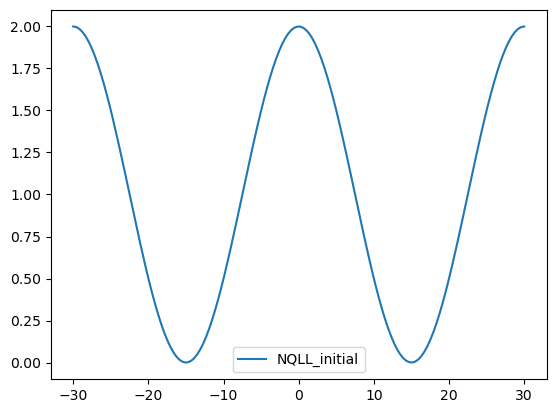

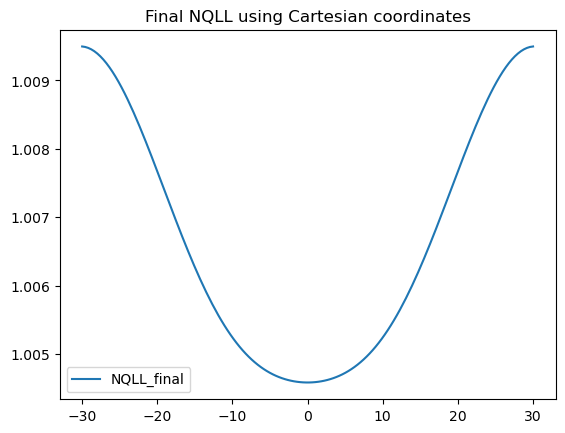

In [177]:
plt.figure()
plt.plot(x_QLC.magnitude, NQLL0, label = "NQLL_initial")
plt.legend()

plt.figure()
plt.plot(x_QLC.magnitude, NQLL, label = 'NQLL_final')
plt.legend()
plt.title('Final NQLL using Cartesian coordinates')

In [178]:
bj_list0 = rfft(NQLL0)
j_list = np.array([j for j in range(len(bj_list0))])
j2_list = np.array(j_list)**2
print(j_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]


In [179]:
# Diffusion term based on FT
def diffusion_term_FT(NQLL0, DoverdeltaX2):
    l = int(len(NQLL0)/2)
    Dcoefficient1 = DoverdeltaX2/l**2*np.pi**2; #print('Dcoefficient1', Dcoefficient1)
    bj_list = rfft(NQLL0)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1  * irfft(cj_list)

    return dy

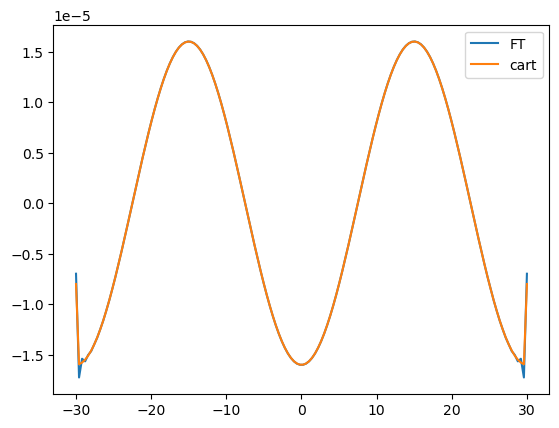

In [180]:
test_FT = diffusion_term_FT(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test_FT, label = 'FT')
plt.plot(x_QLC.magnitude, test, label = 'cart')
plt.legend()

In [181]:
def diffusion_term_FT_b_list(bj_list, D, L):
    Dcoefficient1 = D*np.pi**2/(L**2); #print('Dcoefficient1', Dcoefficient1)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1 * cj_list
    return dy

In [182]:
# Solving in the Fourier domain (i.e., for b_j(t))
tic = time.perf_counter()
bj_list = np.copy(bj_list0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_FT_b_list(bj_list, D.magnitude, L.magnitude)
    bj_list += term_1
toc = time.perf_counter()
print(f"Code took {toc - tic:0.4f} seconds")

Code took 0.0875 seconds


Text(0.5, 1.0, 'Initial and final NQLL using Euler integration, with Fourier coordinates')

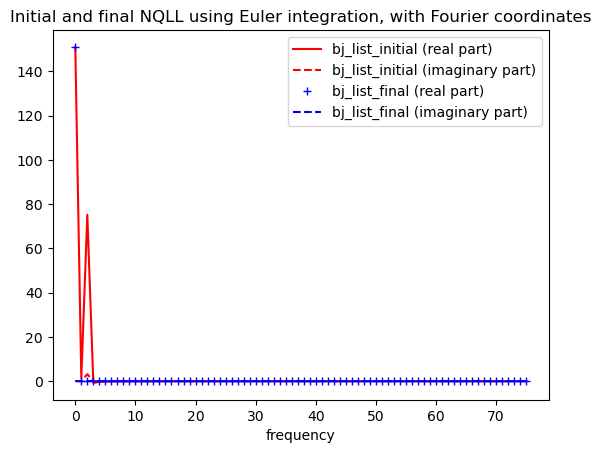

In [183]:
# Graphing the results in the Fourier domain
j_list = np.array([j for j in range(len(bj_list))])
plt.figure()
plt.plot(j_list, np.real(bj_list0), 'r', label = 'bj_list_initial (real part)')
plt.plot(j_list, np.imag(bj_list0), 'r--', label = 'bj_list_initial (imaginary part)')
plt.plot(j_list, np.real(bj_list), 'b+', label = "bj_list_final (real part)")
plt.plot(j_list, np.imag(bj_list), 'b--', label = "bj_list_final (imaginary part)")
plt.legend()
plt.xlabel('frequency')
plt.title('Initial and final NQLL using Euler integration, with Fourier coordinates')

Text(0.5, 1.0, 'Final NQLL using k-space variables "b"')

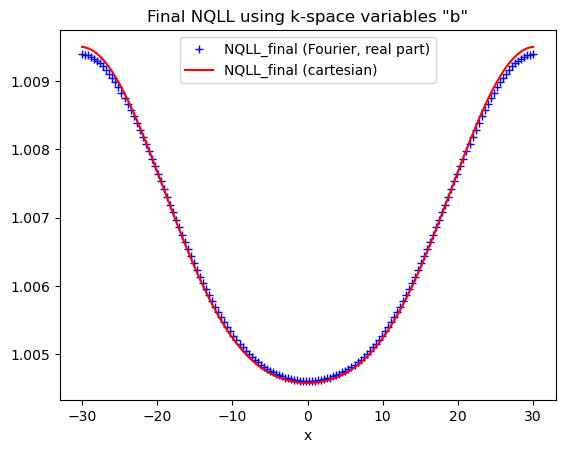

In [184]:
NQLL_FTsolution0 = irfft(bj_list0)
NQLL_FTsolution = irfft(bj_list)
plt.figure()
plt.plot(x_QLC.magnitude,np.real(NQLL_FTsolution), 'b+', label = 'NQLL_final (Fourier, real part)')
plt.plot(x_QLC.magnitude, NQLL, 'r', label = 'NQLL_final (cartesian)')
plt.legend()
plt.xlabel('x')
plt.title('Final NQLL using k-space variables "b"')